In [12]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [13]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [14]:
dogs = pd.read_csv('data/akc.csv').dropna()
earn = (pd.read_csv('data/earnings2020.csv')
        .replace([1, 2, 3, 4, 5], ["<HS", "HS", "<BA", "BA", ">BA"]))

(ch:viz_comparisons)=
# Facilitating Meaningful Comparisons


The same data can be visualized many different ways.
How can we decide between two plots of the same data?
Generally speaking, a plot should help the reader make meaningful
comparisons.
In this section, we go over several useful principles that can improve the
clarity of your plots.

**Emphasize the Important Difference.**
Whenever we make a plot, we should ask: does the plot make the important
difference clear? 
As a rule of thumb, it's easier for readers to see differences when
they are aligned vertically or horizontally in a plot.
Let's look at an example.

*Example: Weekly Earnings for Men and Women in 2020.*
The US Bureau of Labor Statistics publishes data on income.
We've taken the median weekly earnings for people over 25 and plotted them
below.
We've split the incomes by education level and sex.

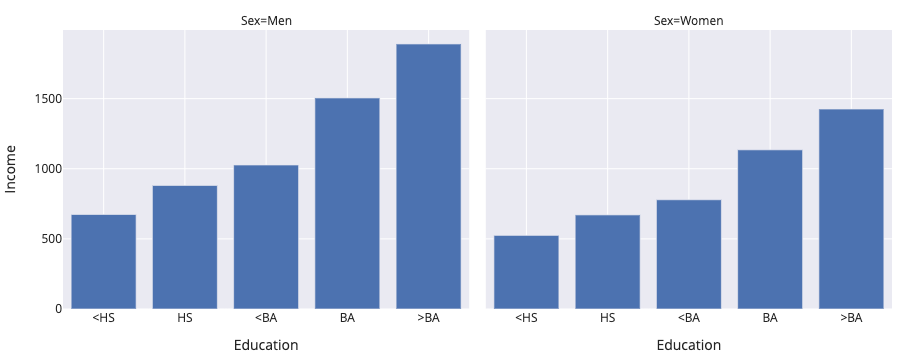

In [15]:
labels = {'educ': 'Education', 'income': 'Income', 'gender':'Sex'}
fig = px.bar(earn, x='educ', y='income', facet_col='gender',
             labels=labels,
             width=450, height=250)
margin(fig, t=30)

These bar plots show that income increases with more education. 
But maybe a more interesting difference is the difference in incomes
between men and women of the same education level.
We could try grouping the bars instead:

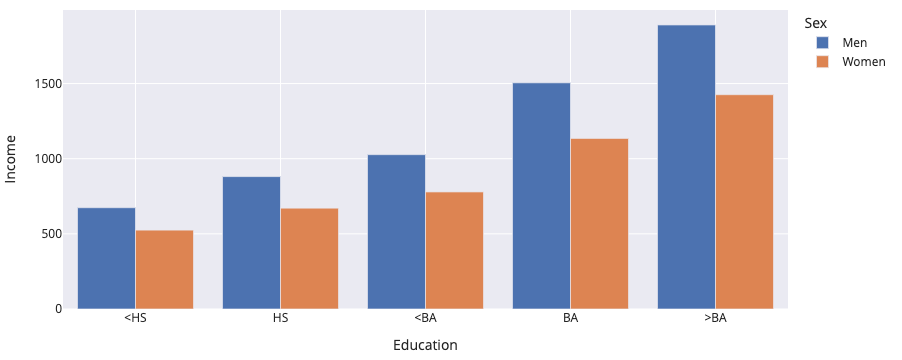

In [16]:
fig = px.bar(earn, x='educ', y='income', color='gender',
             barmode='group',
             labels=labels,
             width=450, height=250)
fig

This is a bit better, but we can make this difference even more clear using
vertical alignment.
Instead of bars, we'll use dots. Then, we can align the dots vertically
for each education level.

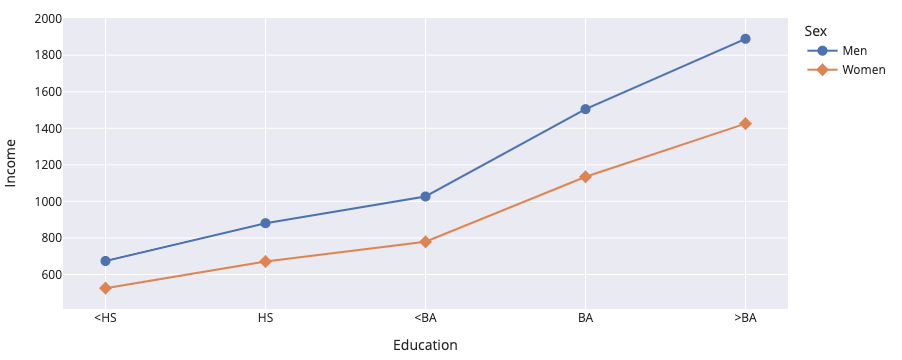

In [17]:
fig = px.line(earn, x='educ', y='income', color='gender', symbol='gender',
              labels=labels,
              markers=True,
              width=450, height=250)
fig.update_traces(marker=dict(size=10))
fig

This plot most clearly shows the most important difference.
It's visually clear that in 2014, the median income for men was
higher than the income for women at each
education level, and that this wage gap is larger at higher education levels.
We considered three plots in this example that all plot the same data.
However, we prefer the last one because it aligns the income
differences vertically, making them easier for readers to see.

**Order by Length.**
For categorical plots like bar plots, we usually order the bars according
to their height, unless we already have a natural order of categories.
In other words, sort the bars for nominal data,
but leave ordinal data in their original order.
There are two bar plots below showing the mean lifespans for dog breeds.
We prefer the plot on the right since 
it has ordered bars, which make it easier to compare
lifespans.

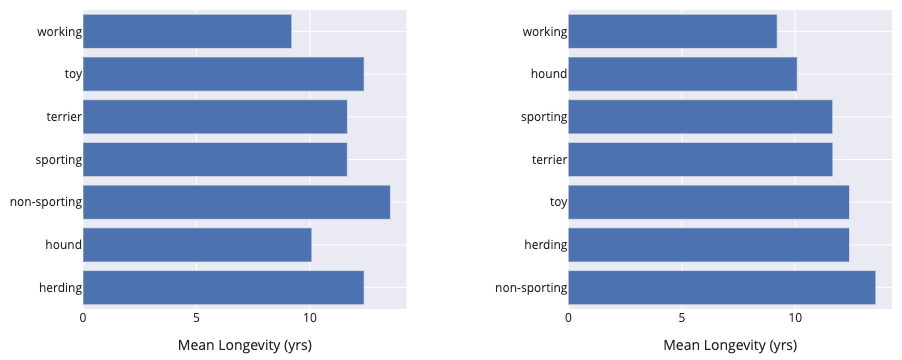

In [18]:
lons = dogs.groupby('group')[['longevity']].mean().reset_index()
f1 = px.bar(lons, x='longevity', y='group')
f2 = px.bar(lons.sort_values('longevity', ascending=False),
            x='longevity', y='group')

fig = left_right(f1, f2, width=600, height=200, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Mean Longevity (yrs)')
fig

**Order by Median.**
With side-by-side box plots we arrange them in order according to their medians 
unless, again, the variable has a natural ordering.
In other words, we prefer the box plot on the right over the one on the left:

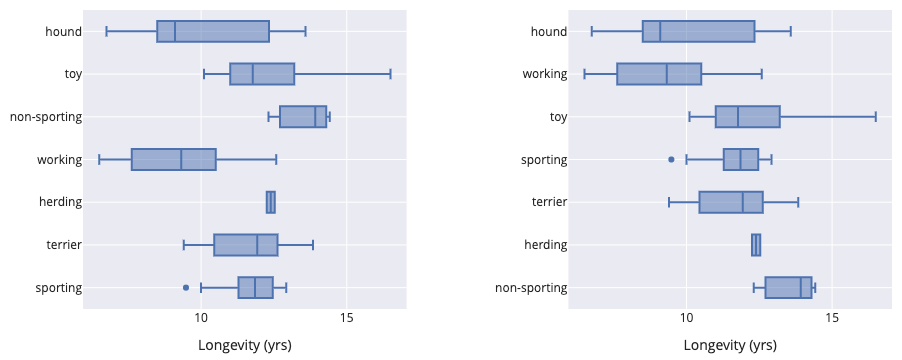

In [19]:
meds = (dogs.groupby('group')
 ['longevity']
 .transform('median')
)
by_medians = (dogs.assign(med=meds)
 .sort_values('med', ascending=False)
)

f1 = px.box(dogs, x='longevity', y='group')
f2 = px.box(by_medians, x='longevity', y='group')
fig = left_right(f1, f2, horizontal_spacing=0.2)
fig.update_xaxes(title_text='Longevity (yrs)')
fig

**Avoid Stacking**.
Stacked bar and line plots hinder comparisons as they lack a constant
baseline.
With the exception of the lowest portions of each bar,
the bottom of each bar in a stacked bar plot moves up and down across groups. 
Stacked line plots are even more difficult to read as the distance from one 
curve to another wiggles up and down.

*Example: CO2 Emissions.* 
The plot below show CO2 emissions from 1950 to 2012 for the 10 countries with
the highest emissions.
But since the lines are stacked of top of each other,
it's very hard to see how the emissions for a particular country have changed.

In [20]:
co2 = pd.read_csv("data/co2_by_country.csv", skiprows = 2,
                  names = ["Country", "Year", "CO2"])
last_year = co2.Year.iloc[-1]
q = (f"Country not in ['World', 'European Union (15)', 'European Union (28)']"
     f"and Year == {last_year}")
top10_lasty = co2.query(q).sort_values('CO2', ascending=False).iloc[:10]
top10 = co2[co2.Country.isin(top10_lasty.Country) & (co2.Year >= 1950)]

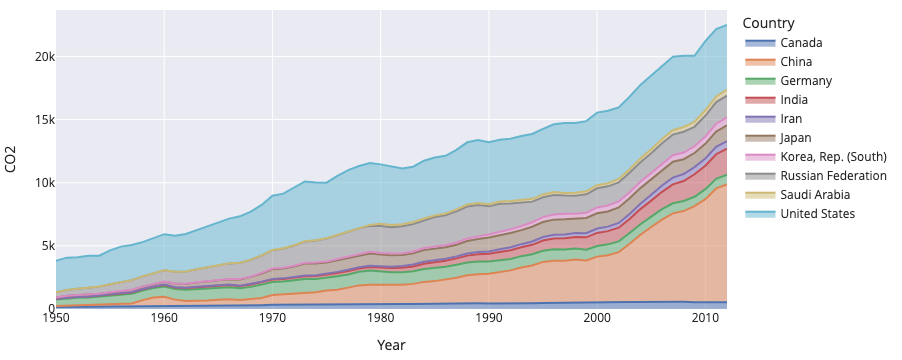

In [21]:
fig = px.area(top10, x='Year', y='CO2',
              color='Country', line_group='Country',
              width=600, height=350)
fig

Instead, we can plot each line separately without stacking, as the plot
below illustrates.
It's much easier to compare individual countries since we can compare 
y-axis positions rather than stacked areas.
We see that some countries have had flat rates of growth in CO2 emissions
(on a log scale)
while others have increased much faster.

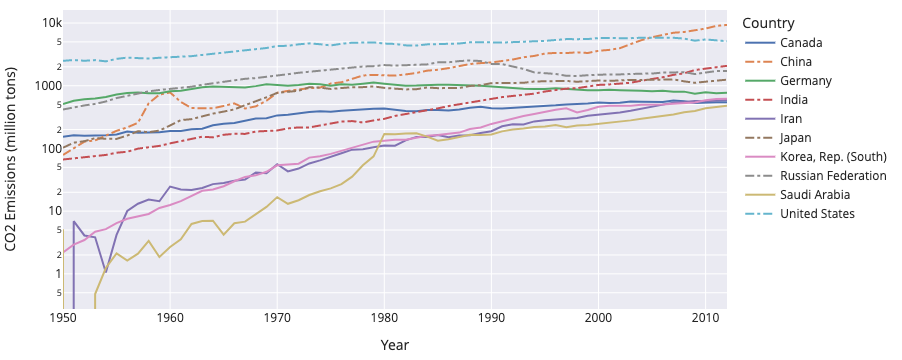

In [22]:
fig = px.line(top10, x='Year', y='CO2', color='Country',
              log_y=True,
              width=600, height=350)

# To make some lines dashed:
from itertools import cycle
styles = cycle([None, 'dashdot'])
for i in range(10):
    fig.update_traces(selector=i, 
                      line = dict(dash=next(styles)))
fig.update_yaxes(title_text='CO2 Emissions (million tons)')
fig

**Compare Positions and Lengths Rather than Angles or Areas.**
People understand visualizations better when the visualization uses
positions and lengths rather than angles and areas.
For instance, pie charts make readers use angles, as the chart of
GDP below shows.
It's hard to use these kinds of plots to make comparisons.
For instance, the difference in GDP between the Americas and Asia is nearly
invisible without using the pie chart labels.

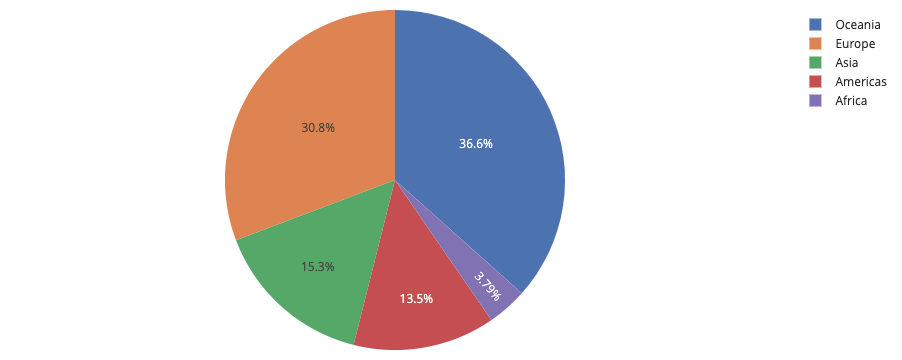

In [23]:
gap = px.data.gapminder()
gdp = (gap
 .query('year == 2007')
 .groupby('continent')
 ['gdpPercap']
 .mean()
 .reset_index()
)
px.pie(gdp, names='continent', values='gdpPercap',
       width=350, height=250)

If we use a simple dot plot instead, the differences are much easier to see.

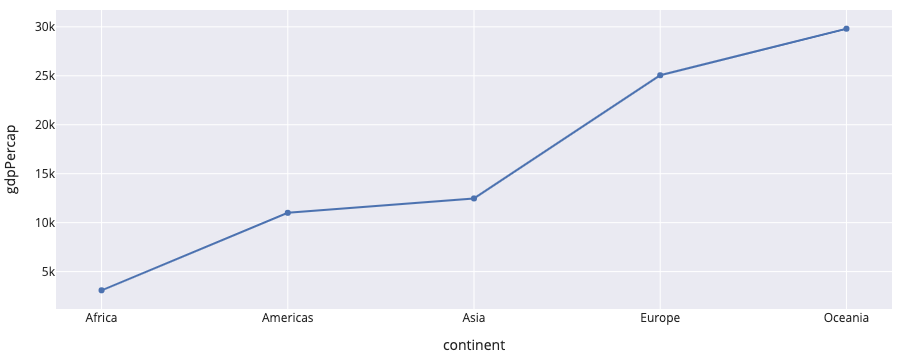

In [24]:
px.line(gdp, x='continent', y='gdpPercap', 
        markers=True,
        width=350, height=250)

Visualization researchers studied how well people can make different kinds of
comparisons. They found the following ordering (from most to least
accurately judged):

1. Positions along a common scale, like in a rug plot, strip plot, or dot plot.
2. Positions on identical, non-aligned scales, like in a bar plot.
3. Length, like in a stacked bar plot.
4. Angle and slope, like in a pie chart.
5. Area, like in a stacked line plot or bubble chart.
6. Volume, density, and color saturation, like in a 3-dimensional bar plot.
7. Color hue, like in a chloropeth election map.

We recommend sticking to positions and lengths.

**Selecting a Color Palette.**
Choosing colors also plays an important role in data visualization.
We want to avoid overly bright or dark colors so that we don't strain
readers' eyes.
We should also avoid color palettes that might be difficult for color-blind
people---7-10% of people (mostly males) are red-green color-blind.

For categorical data, we usually want to use a
color palette that can clearly distinguish between
categories.
One example is shown in {numref}`Figure %s <qual_palette>`, which is 
incidentally the color palette we use for visualizations in this book.

```{figure} figures/qual_palette.svg
---
name: qual_palette
---

An example color palette for categorical data from the `seaborn` Python
package.
```

For numeric data, we want to use a sequential color palette that emphasizes
one side of the spectrum more than the other.
Or, we can use a diverging color palette that emphasizes both ends of the 
spectrum.
An example of a sequential palette is shown in
{numref}`Figure %s <quant_palette>`, and an example of a diverging palette in
{numref}`Figure %s <div_palette>`.

```{figure} figures/quant_palette.png
---
name: quant_palette
---

An sequential color palette for numeric data.
```

```{figure} figures/div_palette.png
---
name: div_palette
---

An diverging color palette for numeric data.
```

We choose a sequential palette when we want to emphasize either low or high
values, like frequency of website visits.
We choose a diverging palette when we want to emphasize both extremes, like
for two-party election results or weather forecasts. 

It's important to choose a perceptually uniform color palette.
The term "perceptually uniform" means that when a data value is doubled,
the color in the visualization looks twice as bright to the human eye.
In essence, we want to avoid colors that create an after-image when
we look from one part of the graph to another, colors of different intensity
that make one attribute appear more important than another, and colors that
color-blind people have trouble distinguishing between.
So, we strongly recommend using a palette or a palette generator 
made specifically for data visualizations.

The use of color should not be gratuitous; that is, colors should
represent information.
Plots are meant to be examined for long periods of time
so we should choose colors that don't impede the reader's ability
to carefully read a plot.
For instance, people
typically have trouble distinguishing between more than about seven colors so
we limit the number of colors used in a plot. Finally, colors can appear quite
different when printed on paper in grayscale or
when viewed on a computer screen.
When we choose colors, we should keep in mind how
our plots will be displayed.

This section covered principles that help visualizations facilitate meaningful
comparisons.
We saw that it's important to pick plots that emphasize the important
differences, and made recommendations for ordering in categorical plots.
We made recommendations to use positions and lengths based on research in
visualization, and provided guidelines for selecting color palettes.
In the next section, we'll talk about how to incorporate the data design in 
visualization.